## make_sbc:
### Make surface boundary conditions.
#### Version id:
#### v1.
#### ACCESS OM2-1

In [4]:
run ='amery_v2km'

import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata


proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)


from ext.tools.NDinterp import NDinterp
from ext.tools.log_progress import log_progress


# set user parameter and call main routine
grd_file = os.path.join(data_dir,'proc','amery_v2km_grd.nc')

# Path to ECCO2 files for temperature and salinity 1th January 2007
access_path = os.path.join(data_dir,'raw','access-om2/')
access_sub_paths = ['./']


In [6]:
# Load ACCESS data

# sfc heat flux
file_list=[]
file_name_format = 'ocean-2d-net_sfc_heating-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list.append(access_path+subfolder+file_name_format)
shflx_full = xr.open_mfdataset(str(*file_list),decode_times=True)

# sfc freshwater flux
file_list=[]
file_name_format = 'ocean-2d-pme_river-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list.append(access_path+subfolder+file_name_format)
swflx_full = xr.open_mfdataset(str(*file_list),decode_times=True)

# x tau
file_list=[]
file_name_format = 'ocean-2d-tau_x-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list.append(access_path+subfolder+file_name_format)
tau_x_full = xr.open_mfdataset(str(*file_list),decode_times=True)

# y tau
file_list=[]
file_name_format = 'ocean-2d-tau_y-1-daily-mean-ym_2007_*.nc'
for subfolder in access_sub_paths:
    file_list.append(access_path+subfolder+file_name_format)
tau_y_full = xr.open_mfdataset(str(*file_list),decode_times=True)

In [85]:
shflx_full.attrs['filename']

'ocean-2d-net_sfc_heating-1-daily-mean-ym_2007_01.nc'

In [7]:
tau_x_full

<xarray.Dataset>
Dimensions:     (xu_ocean: 3600, yu_ocean: 2700, time: 90, nv: 2)
Coordinates:
  * xu_ocean    (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * time        (time) datetime64[ns] 2007-01-01T12:00:00 ... 2007-03-31T12:0...
  * nv          (nv) float64 1.0 2.0
Data variables:
    tau_x       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(90, 2700, 3600), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-tau_x-1-daily-mean-ym_2007_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221106T0435Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [13]:
#load roms grid and convert lon to 0-360

R_grid = xr.open_dataset(grd_file)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

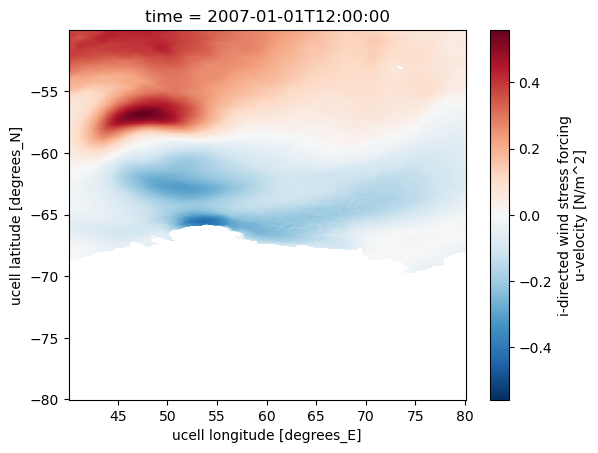

In [77]:
#access wind data is already daily data. So just crop to required geog limits:

tau_x_temporary = tau_x_full.sel(yu_ocean=slice(-80,-50),xu_ocean=slice(40,93))
tau_y_temporary = tau_y_full.sel(yu_ocean=slice(-80,-50),xu_ocean=slice(40,93))
shflx_temporary = shflx_full.sel(yt_ocean=slice(-80,-50),xt_ocean=slice(40,93))
swflx_temporary = swflx_full.sel(yt_ocean=slice(-80,-50),xt_ocean=slice(40,93))
tau_x_temporary.tau_x.isel(time=0).plot()


#get access coordinates
t_lon,t_lat = shflx_temporary.xt_ocean.values,shflx_temporary.yt_ocean.values
u_lon,u_lat = tau_x_temporary.xu_ocean.values,tau_x_temporary.yu_ocean.values
t_lon_2d,t_lat_2d = np.meshgrid(t_lon,t_lat)
u_lon_2d,u_lat_2d = np.meshgrid(u_lon,u_lat)
t_lon_flat,t_lat_flat = t_lon_2d.flatten(),t_lat_2d.flatten()
u_lon_flat,u_lat_flat = u_lon_2d.flatten(),u_lat_2d.flatten()

In [13]:
# #define regridding functions for era and tamura data
# # griddata takes flat arrays of source points and data and interpolates to 2d grid
        

# def regrid_tamura(slon,slat,sdat,tlon,tlat):
    
#     slon = slon[slat<(tlat.max()+2)] # only load data up to 2 deg further north of roms highest latitude
#     sdat = sdat[slat<(tlat.max()+2)]
#     slat = slat[slat<(tlat.max()+2)]
    
#     #tamura comes from npstereo curvilinear grid
#     #we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
#     # otherwise we get an interpolation gap between 0/360
    
#     ii1 = (slon<2.0)

#     slon_ext1 = slon[ii1]
#     slon_ext1[slon_ext1<=1]+=360

#     ii2 = (slon>358.0)

#     slon_ext2 = slon[ii2]
#     slon_ext2[slon_ext2>=359]-=360
    
#     slon_ext = np.hstack((slon_ext1,slon_ext2))
#     slat_ext = np.hstack((slat[ii1],slat[ii2]))
#     sdat_ext = np.hstack((sdat[ii1],sdat[ii2]))
      
#     slon = np.hstack((slon,slon_ext))
#     slat = np.hstack((slat,slat_ext))
#     sdat = np.hstack((sdat,sdat_ext))

#     tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
    
#     return tdat

In [14]:
# # era is more easy, since its on a mercator projection
# # we just have to extend the arrays at the beginning and end to bridge the gap at 0/360

# def regrid_era(slon_raw,slat,sdat_raw,tlon,tlat):
    
#     slon = np.zeros(np.size(slon_raw)+2)
#     slon[0] = slon_raw[-1]-360
#     slon[1:-1] = slon_raw[:]
#     slon[-1] = slon_raw[0]+360

#     slon, slat = np.meshgrid(slon,slat)
    
#     sdat = np.zeros((np.size(sdat_raw,0),np.size(sdat_raw,1)+2))
#     sdat[:,0] = sdat_raw[:,-1]
#     sdat[:,1:-1] = sdat_raw[:,:]
#     sdat[:,-1] = sdat_raw[:,0]
    
#     slon = slon[slat<(tlat.max()+2)]
#     sdat = sdat[slat<(tlat.max()+2)]
#     slat = slat[slat<(tlat.max()+2)]

#     tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
#     return tdat

In [10]:
def regrid_access(slon,slat,sdat,tlon,tlat):
    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat    

In [34]:
swflx_temporary

<xarray.Dataset>
Dimensions:     (xt_ocean: 400, yt_ocean: 639, time: 90, nv: 2)
Coordinates:
  * xt_ocean    (xt_ocean) float64 40.05 40.15 40.25 40.35 ... 79.75 79.85 79.95
  * yt_ocean    (yt_ocean) float64 -79.97 -79.93 -79.88 ... -50.16 -50.09 -50.03
  * time        (time) datetime64[ns] 2007-01-01T12:00:00 ... 2007-03-31T12:0...
  * nv          (nv) float64 1.0 2.0
Data variables:
    pme_river   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(90, 639, 400), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(90,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(90, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-2d-pme_river-1-daily-mean-ym_2007_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20221106T0435Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [93]:
month

'apr'

In [90]:
# MAKE THE MAGIC HAPPEN FOR 2007 AND save in interim folder
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#
#daysPerMonth = [1]

dayOfYear = 1

for month,days,month_nb in zip(month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        #Eidx continues through the year
        #Tidx repeats through the days of the months
        
        # select the daily data from the access data ds
        
        shflux_tmp = shflx_temporary.net_sfc_heating.isel(time=Eidx) #load from the DOY index 
        ssflux_tmp = swflx_temporary.pme_river.isel(time=Eidx)
        
        shflux_tmp
        
        # #read in Tamura heat and fresh water flux and turn in right position
        # shflux_tmp = np.flipud(T_data[0,Tidx])
        # ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        # #fill in tamuar mask for later resampling
        # shflux_tmp[T_mask==0] = np.nan
        # shflux_tmp = NDinterp(shflux_tmp)
        
        # ssflux_tmp[T_mask==0] = np.nan
        # ssflux_tmp = NDinterp(ssflux_tmp)
        
        # shflux_tmp = regrid_tamura(T_lon,T_lat,shflux_tmp,R_lon,R_lat) 
        # ssflux_tmp = regrid_tamura(T_lon,T_lat,ssflux_tmp,R_lon,R_lat)
        
        # shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        shflux_tmp = regrid_access(t_lon_flat,t_lat_flat,shflux_tmp.values.flatten(),R_lon,R_lat) 
        ssflux_tmp = regrid_access(t_lon_flat,t_lat_flat,ssflux_tmp.values.flatten(),R_lon,R_lat) 
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        refSalt = 34.4

        ds.swflux[Tidx] = ssflux_tmp/refSalt*100
        del ssflux_tmp
        
        #select access stress fields
        taux = tau_x_temporary.tau_x.isel(time=Eidx).values
        tauy = tau_y_temporary.tau_y.isel(time=Eidx).values
        
        #rotate wind directions to roms grid
        uv = (taux+1j*tauy)*np.exp(1j*-(u_lon_2d/180*np.pi))
        taux_rot = uv.real
        tauy_rot = uv.imag
        
        
        taux = regrid_access(u_lon_flat,u_lat_flat,taux_rot.flatten(),R_ulon,R_ulat)
        tauy = regrid_access(u_lon_flat,u_lat_flat,tauy_rot.flatten(),R_vlon,R_vlat)
        
        
        # #convert to stress
        # signu = np.sign(uwnd)
        # signv = np.sign(vwnd)

        # rhoAir = 1.3
        # Cd = 1.4e-3

        # taux = rhoAir*Cd*np.square(uwnd)*signu
        # tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uv
        
        ds.sustr[Tidx]= taux
        ds.svstr[Tidx]= tauy
        
        
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'waom surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'heat_flux_file':shflx_full.attrs['filename'],
                          'salt_flux_file':swflx_full.attrs['filename'],
                          'uwind_file':tau_x_full.attrs['filename'],
                          'vwind_file':tau_y_full.attrs['filename'],
                          'grid file':grd_file,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'centimetre day-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        int_path = os.path.join(data_dir,'cache',run+'_'+var+'_'+month_nb+'.nc')
        print("Saving month to "+int_path)
        ds[var].to_netcdf(int_path,'w',unlimited_dims=dim)
    #del ds
    
    #update the day of the year value for next month
    dayOfYear += days

Processing month:  jan with days:  31
Containing days of year:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_shflux_01.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_swflux_01.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_sustr_01.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_svstr_01.nc
Processing month:  feb with days:  28
Containing days of year:  [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59]


Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_shflux_02.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_swflux_02.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_sustr_02.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_svstr_02.nc
Processing month:  mar with days:  31
Containing days of year:  [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90]


Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_shflux_03.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_swflux_03.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_sustr_03.nc
Saving month to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_svstr_03.nc
Processing month:  apr with days:  30
Containing days of year:  [ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120]


IndexError: index 90 is out of bounds for axis 0 with size 90

In [95]:
#collect all interim results, merge to yearly data amd adjust cycle length attribute
#save forcing files in processed folder
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    ds = xr.open_mfdataset(os.path.join(data_dir,'cache',run+'_'+var+'_??.nc'))
    ds[dim]
    ds[dim].attrs['cycle_length'] = float(365)
    out_path = os.path.join(data_dir,'proc',run+'_'+var+'.nc')
    print('saving final to'+out_path)
    ds.to_netcdf(out_path,'w')

saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_shflux.nc
saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_swflux.nc
saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_sustr.nc
saving final to/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_svstr.nc


In [ ]:
STOP

# below just devel stuff

In [97]:
ds

<xarray.Dataset>
Dimensions:   (sms_time: 90, eta_v: 749, xi_v: 900)
Coordinates:
  * sms_time  (sms_time) int64 1 2 3 4 5 6 7 8 9 ... 82 83 84 85 86 87 88 89 90
Dimensions without coordinates: eta_v, xi_v
Data variables:
    svstr     (sms_time, eta_v, xi_v) float64 dask.array<chunksize=(31, 749, 900), meta=np.ndarray>

AttributeError: 'Dataset' object has no attribute 'sustr'

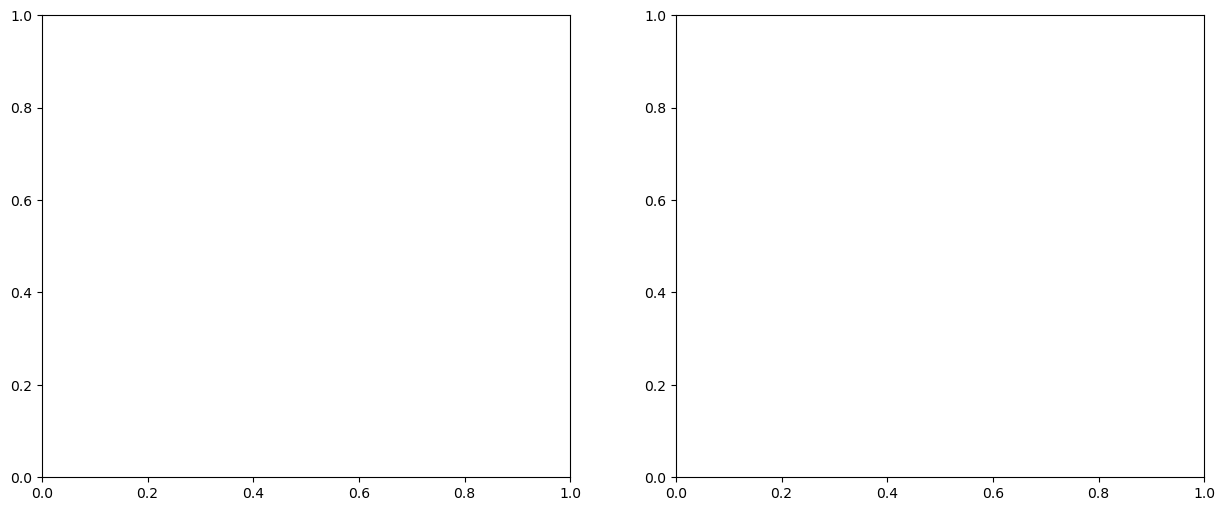

In [96]:
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.sustr.plot(ax=ax0,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
old.sustr[0].plot(ax=ax1,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


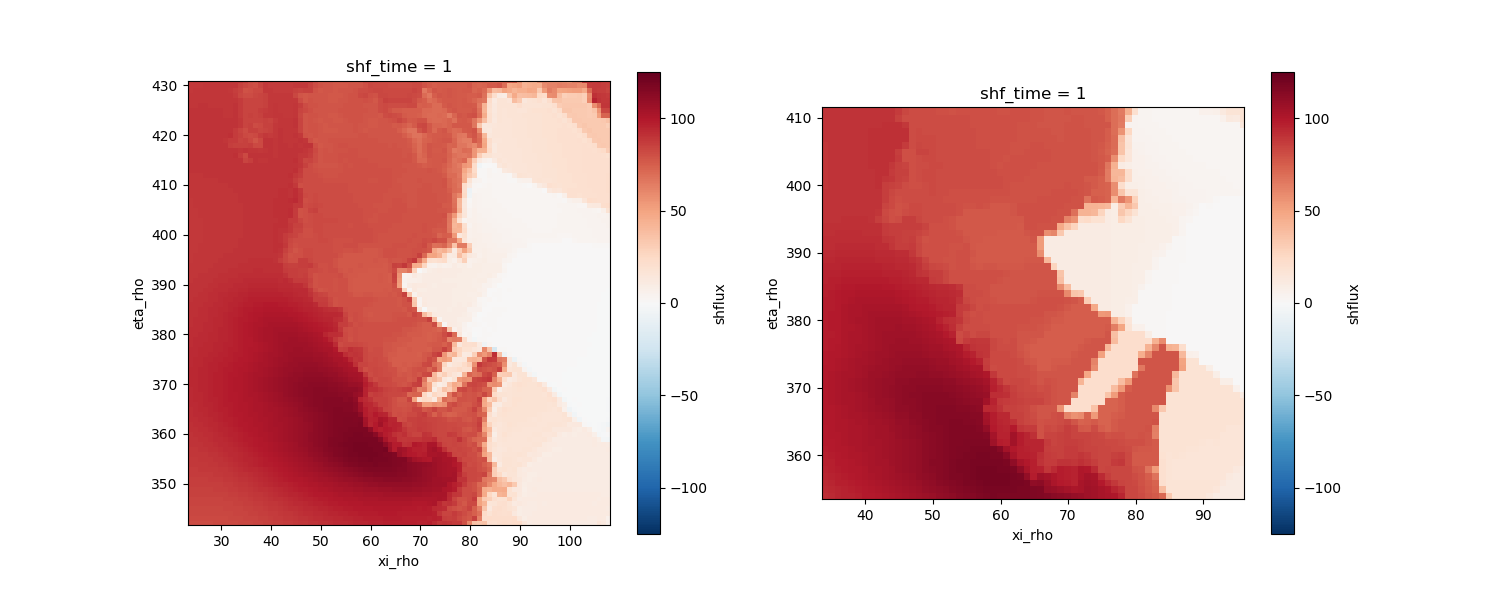

In [58]:
%matplotlib notebook
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.shflux.plot(ax=ax0)
old_shflx.shflux[0].plot(ax=ax1)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

In [56]:
path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_sustr.nc')
old_sustr = xr.open_dataset(path)

path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_shflux.nc')
old_shflx = xr.open_dataset(path)